In [1]:
#!pip3 install scikit-learn pandas scipy 

# Classification

## Gathering data

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

X.shape

(70000, 784)

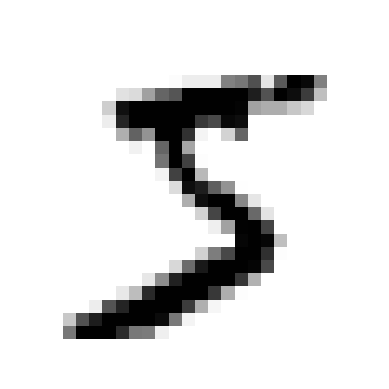

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
some_digit = np.array(X.loc[:0])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

casting label as integer

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:],y[60000:]

## Training a Binary Classifier

In [7]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict(X[:2])

array([ True, False])

### Implementing Cross-Validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

stat_kfold = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
for train_index, test_index in stat_kfold.split(X_train,y_train_5):
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints the accuracy on each fold

0.9669
0.91625
0.96785


### Cross validation

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred= cross_val_predict(sgd_clf, X_train, y_train_5)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

### Precision & Recall

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [13]:
recall_score(y_train_5,y_train_pred)

0.8310274857037447

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7910447761194029

### Precision/Recall Trade-Off

In [15]:
y_scores = sgd_clf.decision_function([X.iloc[0]])
print(y_scores)
threshold = 0
y_pred_manually = (y_scores > threshold) #manually checking if the score of label is more than threshold
y_pred_manually

[2164.22030239]


/Volumes/Vivek Drive/Skill/Machine/Hand-On Machine/classification_problem/classification/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')

In [17]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5,y_scores)

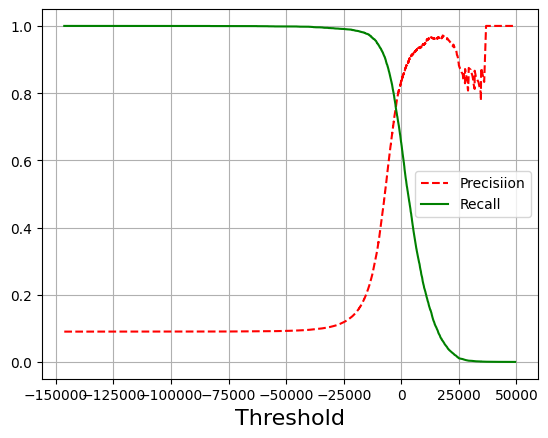

In [18]:
def PR_graph(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], 'r--', label = 'Precisiion')
    plt.plot(threshold, recall[:-1], 'g-',label = 'Recall')
    plt.legend()
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                 
    plt.show()
PR_graph(precision,recall, threshold)

### ROC Curve

In [19]:
from sklearn.metrics import roc_curve
fpr, tpr , thresholds = roc_curve(y_train_5,y_scores)

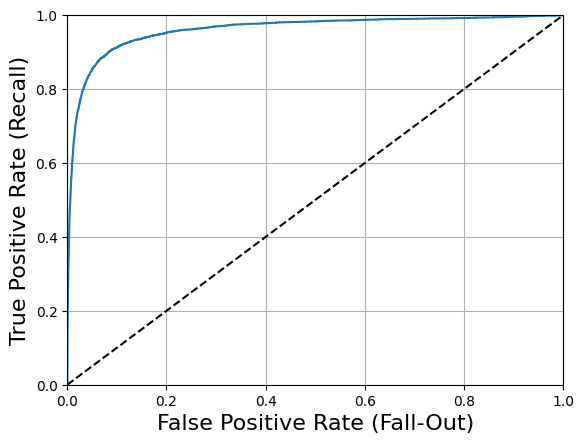

In [20]:
def plot_roc_curve(fpr,tpr,label =None):
    plt.plot(fpr,tpr, label =None)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)    

plot_roc_curve(fpr, tpr)

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Trying random forest algorithm for better roc_auc_score

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv = 3, n_jobs=-1, method='predict_proba')


In [23]:
y_score_forest = y_probas_forest[:,1]

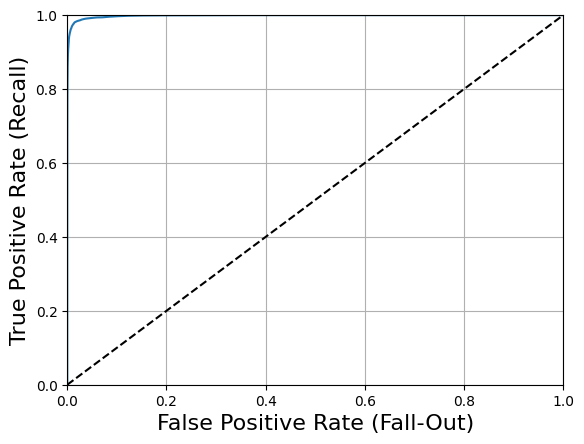

In [24]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)
plot_roc_curve(fpr_forest,tpr_forest)


In [25]:
roc_auc_score(y_train_5,y_score_forest)

0.9983296721818179

In [26]:
precision_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5,y_score_forest)

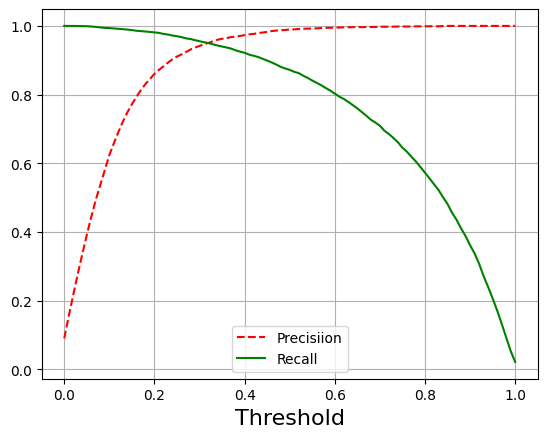

In [27]:
PR_graph(precision_forest,recall_forest,threshold_forest)

In [28]:
y_pred_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3, n_jobs=-1)
precision_score(y_train_5,y_pred_forest)

0.9898819561551433

In [29]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

## Multiclass Classification

Using SGD Classifier as OvA

In [30]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
print(svm_clf.score(X_train[:1000], y_train[:1000]))

1.0


In [31]:
some_digit_scores = svm_clf.decision_function(X[:1])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [32]:
multi_predict = svm_clf.predict(X[-5:])
print(multi_predict)
print(y_train[-5:])

[7 7 7 7 7]
59995    8
59996    3
59997    5
59998    6
59999    8
Name: class, dtype: uint8


Above model is overfitting

In [33]:
from sklearn.multiclass import OneVsOneClassifier
ovr_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
print(ovr_clf.predict(X[-5:]))
print(y_train[-5:]) #overfitting

[7 7 7 7 7]
59995    8
59996    3
59997    5
59998    6
59999    8
Name: class, dtype: uint8


In [34]:
len(ovr_clf.estimators_)

45

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_scaled, y_train, cv =3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [36]:
y_train_pred = cross_val_predict(sgd_clf,X_scaled,y_train,cv = 3 )
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

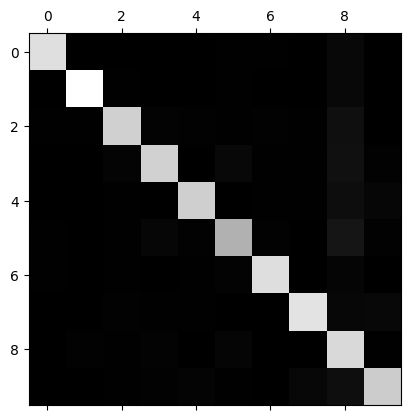

In [38]:
plt.matshow(conf_mx, cmap= plt.cm.gray)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

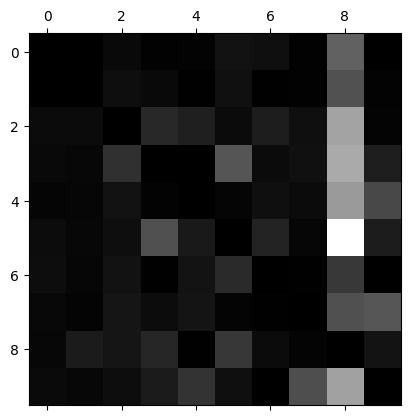

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show

MultiLabel Classification

In [61]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [51]:
knn_clf.predict(X_train[-5:])

array([[ True, False],
       [False,  True],
       [False,  True],
       [False, False],
       [ True, False]])

In [52]:
y_multilabel[-5:]

array([[ True, False],
       [False,  True],
       [False,  True],
       [False, False],
       [ True, False]])

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=2)
# 

In [65]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9735086054032636

Multioutput Classfication

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train.shape

(60000, 784)

In [57]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100 , (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [68]:
knn_clf.fit(X_train_mod, y_train_mod)


KNeighborsClassifier()

In [112]:
np.array(X_test_mod.iloc[1:2])

array([[ 93,  43,  90,  27,  48,   2,   3,  93,   6,  29,  29,  40,  48,
         46,  93,  67,  51,  49,  35,  22,  40,  53,  47,  36,   0,  59,
         74,  38,  96,  27,  35,  69,  94,  13,  69,  98,  38,  85,  76,
         81,   3,   8,  46,  67,  88,  89,  23,   7,  84,  36,  29,  47,
         52,  19,  79,  25,  34,  99,  66,  11,  17,  12,  29,  42,  65,
         11,  17,  82,  21,  77,  79,  57,  89,  68,  90,  90,   0,  47,
         48,  41,  70,  44,  60,  46,  69,  40,  79,  63,  38,   7,  49,
         37,  17,   6, 150, 157, 172, 332, 328, 206, 180,  50,  56,  93,
         85,  10,  48,  52,  48,  43,  46,  27,  25,  33,  88,  88,  11,
         51,  55,  80,  16, 210, 262, 316, 335, 283, 311, 282, 285,  94,
         78,  91,  48,  10,  34,   4,  21,  10,  38,  71,  66,  38,  47,
         64,  19,  44,   5,  30, 225, 313, 265, 352, 283, 203, 247, 282,
        277, 196,  79,  43,  71,  93,  41,  99,   6,  73,  65,  61,  10,
         24,  85,  48,  94,  18,  54, 143, 257, 297

In [117]:
clean_digit = knn_clf.predict(np.array(X_test_mod.iloc[100:101]))

/Volumes/Vivek Drive/Skill/Machine/Hand-On Machine/classification_problem/classification/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


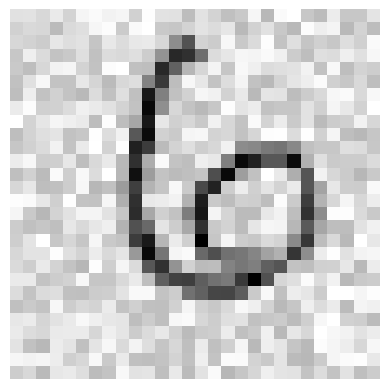

In [118]:

plot_digit(np.array(X_test_mod.iloc[100:101]))

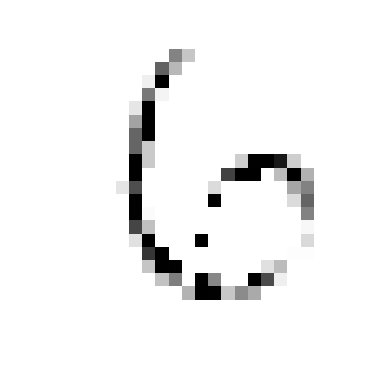

In [119]:
plot_digit(clean_digit)

## Exercises

### Q1
An MNIST Classifier With Over 97% Accuracy

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn_clf = KNeighborsClassifier()
hype_params = [
    {'weights' : ["uniform", "distance"], 'n_neighbors'  : [3,4,5]}
]
grid_search = GridSearchCV(knn_clf, hype_params, cv=5,verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time= 5.6min
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time= 5.7min
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time= 5.8min
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time= 5.8min
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time= 5.8min
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time= 5.8min
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time= 5.8min
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time= 5.8min
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time= 5.6min
[CV 1/5] END ...n_neighbors=4, weights=distance;, score=0.973 total time= 5.5min
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time= 5.8min
[CV 4/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [8]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

In [9]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

### Q2
Data Augmentation

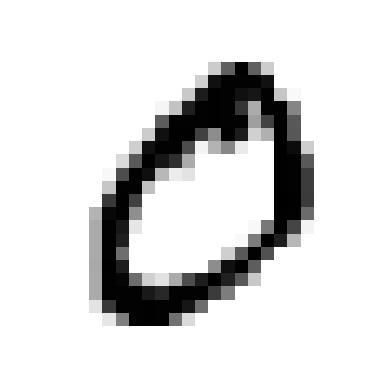

In [16]:
one_image = np.array(X_train.iloc[1])
plot_digit(one_image)

Shifting one pixel

In [18]:
from scipy.ndimage import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [29]:
X_train_image = [np.array(X_train.iloc[i]) for i in range(0,len(X_train)-1)]
y_train_label = [np.array(y_train.iloc[i]) for i in range(0,len(y_train)-1)]
for dx, dy in ((1,0),(0,1),(0,-1), (-1,0)):
    for i in range(0,len(X_train)-1):
        X_train_image.append(shift_image(np.array(X_train.iloc[i]), dx , dy))
        y_train_label.append(np.array(y_train.iloc[i]))

X_train_image = np.array(X_train_image)
y_train_label = np.array(y_train_label)

In [30]:
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train_image,y_train_label)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [31]:
y_pred = best_knn.predict(X_test)

/Volumes/Vivek Drive/Skill/Machine/Hand-On Machine/classification_problem/classification/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [32]:
accuracy_score(y_test,y_pred)

0.9763